In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import pytz
import pandas as pd
import numpy as np
import re
import string as s
%matplotlib inline
import matplotlib.dates as dates


In [2]:
SOCKET_TRANSACTION  = 1
HTTP_TRANSACTION = 2
HTTP_LOGIN = 3
HTTP_PAYMENT = 4

def convToInt(x):
    return int(x)

def convToFloat(x):
    if x:
        return float(x)
    else:
        return 0

def parse_datetime(x):
    if x:
        return datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
    else:
        return ''        
        

def conv_Type_to_int(x):
    if x == 'socket':
        return 1
    else:
        return 2

In [3]:
LOG_SENDER = 'fis20190301162115__sender.log'
LOG_RECEIVER = 'fis20190301162115__receiver.log'
def getnsusender(x):
    return x[208:220]
             
def getnsureceive(x):
    return x[188:200]

sender_log = pd.read_csv(LOG_SENDER,
                      delimiter=';', 
                      engine='python',
                      na_values='-', 
                      header=0,
                      names=['date','type','msgid','message','tps'],
                      converters={'date': parse_datetime,
                                  'msgid': convToInt,
                                  'tps': convToFloat,
                                  'type':conv_Type_to_int
                              }
                        )

sender_log['NSU'] = [getnsusender(x) for x in sender_log['message']]

receiver_log = pd.read_csv(LOG_RECEIVER,
                      delimiter=';', 
                      engine='python',
                      na_values='-', 
                      header=0,
                      names=['date','type','msgid','message','tps'],
                      converters={'date': parse_datetime,
                                  #'msgid': convToInt,
                                  'tps': convToFloat,
                                  'type':conv_Type_to_int
                              })

receiver_log['NSU'] = [getnsureceive(x) for x in receiver_log['message']]

In [30]:
receiver_log.head()

,date,type,msgid,message,tps,NSU
0,2019-03-01 16:21:16.949,1,8EE4C0,3031313046413343323030313845453443303030303030...,1.0,303030303030
1,2019-03-01 16:21:18.214,1,8EE4C0,3031313046413343323030313845453443303030303030...,1.0,303030303031
2,2019-03-01 16:21:18.896,1,8EE4C0,3031313046413343323030313845453443303030303030...,1.0,303030303032
3,2019-03-01 16:21:20.015,1,8EE4C0,3031313046413343323030313845453443303030303030...,1.0,303030303033
4,2019-03-01 16:21:20.797,1,8EE4C0,3031313046413343323030313845453443303030303030...,1.0,303030303034


In [35]:
sender_log.head()

,date,type,msgid,message,tps,NSU
0,2019-03-01 16:21:15.240,1,2,01A3303130304641424436373431413845314338353030...,1.0,303030303030
1,2019-03-01 16:21:16.236,1,3,01A3303130304641424436373431413845314338353030...,1.0,303030303031
2,2019-03-01 16:21:17.237,1,4,01A3303130304641424436373431413845314338353030...,1.0,303030303032
3,2019-03-01 16:21:18.235,1,5,01A3303130304641424436373431413845314338353030...,1.0,303030303033
4,2019-03-01 16:21:19.235,1,6,01A3303130304641424436373431413845314338353030...,1.0,303030303034


In [4]:
lt_datahora = []
lt_msid = []
lt_tempotrans = []
lt_rampup = []

def localizarRetorno(dataIni, pesq):
    dtf = receiver_log.loc[(receiver_log['NSU'] == pesq)==True]['date']
    result = 0
    if not dtf.empty:
                
        return int((dtf.values[0] - dataIni))/1000000
    return result

for ar in sender_log.to_records(index=True):
    hora = str(ar[1])
    hora =hora[0:10]+ ' ' + hora[11:19]
    hora = datetime.strptime(hora, '%Y-%m-%d %H:%M:%S')
    lt_datahora.append(hora)
    lt_msid.append(ar[6])
    lt_tempotrans.append(localizarRetorno(ar[1], ar[6]))
    lt_rampup.append(ar[5])

dfdados = pd.DataFrame({'DataHora' : lt_datahora,
                        'NSU': lt_msid,
                        'ResponseTime': lt_tempotrans,
                        'RampUP' : lt_rampup
})
dfdados = dfdados.set_index('DataHora')
dfdados.head()

,NSU,ResponseTime,RampUP
DataHora,,,
2019-03-01 16:21:15,303030303030,1709.0,1.0
2019-03-01 16:21:16,303030303031,1978.0,1.0
2019-03-01 16:21:17,303030303032,1659.0,1.0
2019-03-01 16:21:18,303030303033,1780.0,1.0
2019-03-01 16:21:19,303030303034,1562.0,1.0


In [7]:
gp_Pct = dfdados.groupby('DataHora').agg({    
    'ResponseTime': ['mean'],
    'NSU': ['count'],
    'RampUP': ['max']
})

gp_Pct.head()

,ResponseTime,NSU,RampUP
,mean,count,max
DataHora,,,
2019-03-01 16:21:15,1709.0,1,1.0
2019-03-01 16:21:16,1978.0,1,1.0
2019-03-01 16:21:17,1659.0,1,1.0
2019-03-01 16:21:18,1780.0,1,1.0
2019-03-01 16:21:19,1562.0,1,1.0


AttributeError: Unknown property autopct

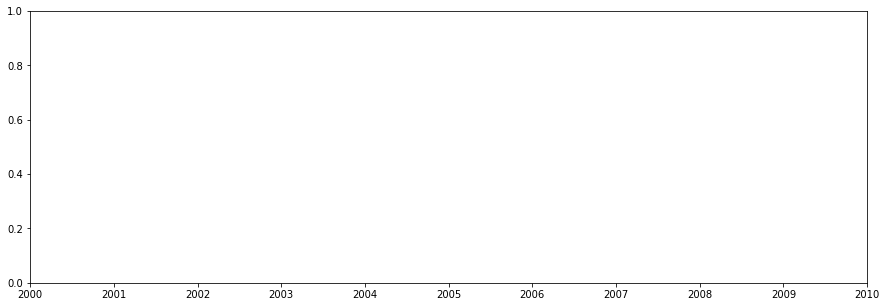

In [5]:
gp_Pct = dfdados.groupby('DataHora').agg({    
    'ResponseTime': ['mean'],
    'NSU': ['count'],
    'RampUP': ['max']
})


fig, ax1 = plt.subplots(figsize=(15, 5))
#first_legend = plt.legend(loc=1)
ax1.stackplot(gp_Pct.index, gp_Pct[('RampUP','max')], color='orange',autopct = '%1.1f%%')
ax1.set_ylabel("TPS")
ax1.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax1.tick_params(labelrotation=45)
ax1.xaxis.set_major_locator(dates.MinuteLocator(byminute=None, interval=3))
ax1.legend(['Ramp up'], loc=2)

ax2 = ax1.twinx() 
ax2.plot(gp_Pct.index, gp_Pct[('ResponseTime','mean')], color='black')
ax2.set_ylabel("Milissegundos")
ax2.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax2.tick_params(labelrotation=45)
ax2.xaxis.set_major_locator(dates.MinuteLocator(byminute=None, interval=3))
ax2.legend(['Response Time'], loc=0)

In [49]:
gp_Pct = dfdados.groupby(['DataHora', 'RampUP']).agg({    
    
    'NSU': ['count']
})


In [8]:

writer = pd.ExcelWriter("ParseInetora.xlsx", engine='xlsxwriter')
gp_Pct.to_excel(writer, sheet_name='Plan1')
writer.save()

In [16]:
gpsender  = sender_log
gpsender = gpsender.set_index('date')
gpsender = gpsender.groupby([gpsender.index.hour, gpsender.index.minute, 'tps']).agg({    
    'tps': ['count']
})
gpsender



tps
               count
date date tps       
16   21   1.0     45
     22   1.0     60
     23   1.0     60
     24   1.0     16
          2.0     88
     25   2.0    120
     26   2.0    120
     27   2.0     34
          3.0      3
          5.0    210
     28   5.0    300
     29   5.0    300
     30   5.0     90
          6.0      6
          7.0    287
     31   7.0    420
     32   7.0    420
     33   7.0    133
          8.0      8
          10.0   400
     34   10.0   600
     35   10.0   600
     36   10.0   200
          11.0    11
          12.0   468
     37   12.0   720
     38   12.0   720
     39   12.0   252
          13.0    13
          15.0   570
...              ...
     42   15.0   330
          16.0    16
          18.0   666
     43   18.0  1080
     44   18.0  1080
     45   18.0   414
          19.0    19
          22.0   792
     46   22.0  1320
     47   22.0  1320
     48   22.0   528
          23.0    23
          25.0   875
     49   25.0  1500
     50   25.0  1500
     51   25.0   625
          26.0    26
          28.0   952
     52   28.0  1680
     53   28.0  1680
     54   28.0   728
          29.0    29
          32.0  1056
     55   32.0  1920
     56   32.0  1920
     57   32.0   864
          33.0    33
          35.0  1120
     58   0.0      1
          35.0   784

[62 rows x 1 columns]

In [17]:
gpreceive  = receiver_log
gpreceive = gpreceive.set_index('date')
gpreceive = gpreceive.groupby([gpreceive.index.hour, gpreceive.index.minute, 'tps']).agg({    
    'tps': ['count']
})
gpreceive

tps
               count
date date tps       
16   21   1.0     44
     22   1.0     60
     23   1.0     60
     24   1.0     16
          2.0     87
     25   2.0    120
     26   2.0    120
     27   2.0     34
          3.0      1
          5.0    209
     28   5.0    295
     29   5.0    305
     30   5.0     90
          7.0    289
     31   7.0    416
     32   7.0    426
     33   7.0    133
          9.0      3
          10.0   393
     34   10.0   609
     35   10.0   590
     36   10.0   210
          11.0     1
          12.0   462
     37   12.0   682
     38   12.0   755
     39   12.0   251
          13.0     5
          14.0     4
          15.0   559
...              ...
     49   25.0   965
     50   25.0   968
     51   25.0   399
          26.0     6
          27.0     3
          28.0   453
     52   28.0  1014
     53   28.0  1002
     54   28.0   455
          29.0     7
          30.0     5
          31.0     3
          32.0   550
     55   32.0   949
     56   32.0   920
     57   32.0   460
          33.0     3
          34.0     6
          35.0   570
     58   35.0  1005
     59   35.0  1035
17   0    35.0   428
          37.0     7
          38.0   516
     1    38.0   921
     2    38.0   311
     3    38.0    91
          40.0    95
     4    40.0   187
     5    40.0    96

[79 rows x 1 columns]